In [ ]:
# Importing essential libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importing specific modules from libraries
from torchvision import transforms
from os import path
from scipy.ndimage import rotate
from torch import nn
from sklearn.metrics import confusion_matrix

# Importing utility modules
import random
from torch.utils.data import Dataset, DataLoader, sampler
from copy import deepcopy
import nibabel as nib

In [ ]:
!wget --show-progress --verbose --tries=3 --no-check-certificate https://aramislab.paris.inria.fr/files/data/databases/DL4MI/OASIS-1-dataset_pt_new.tar.gz

--2024-05-30 20:42:16--  https://aramislab.paris.inria.fr/files/data/databases/DL4MI/OASIS-1-dataset_pt_new.tar.gz
Resolving aramislab.paris.inria.fr (aramislab.paris.inria.fr)... 128.93.101.235
Connecting to aramislab.paris.inria.fr (aramislab.paris.inria.fr)|128.93.101.235|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1387416064 (1.3G) [application/octet-stream]
Saving to: ‘OASIS-1-dataset_pt_new.tar.gz’

OASIS-1-dataset_pt_ 100%[===================>]   1.29G  21.5MB/s    in 66s     

2024-05-30 20:43:24 (20.1 MB/s) - ‘OASIS-1-dataset_pt_new.tar.gz’ saved [1387416064/1387416064]



In [ ]:
! tar xf OASIS-1-dataset_pt_new.tar.gz -C ./

   participant_id session_id alternative_id_1 sex  education_level  age_bl  \
0  sub-OASIS10001    ses-M00    OAS1_0001_MR1   F              2.0      74   
1  sub-OASIS10002    ses-M00    OAS1_0002_MR1   F              4.0      55   
2  sub-OASIS10003    ses-M00    OAS1_0003_MR1   F              4.0      73   
3  sub-OASIS10004    ses-M00    OAS1_0004_MR1   M              NaN      28   
4  sub-OASIS10005    ses-M00    OAS1_0005_MR1   M              NaN      18   

  diagnosis_bl laterality   MMS  cdr_global diagnosis  
0           CN          R  29.0         0.0        CN  
1           CN          R  29.0         0.0        CN  
2           AD          R  27.0         0.5        AD  
3           CN          R  30.0         NaN        CN  
4           CN          R  30.0         NaN        CN  


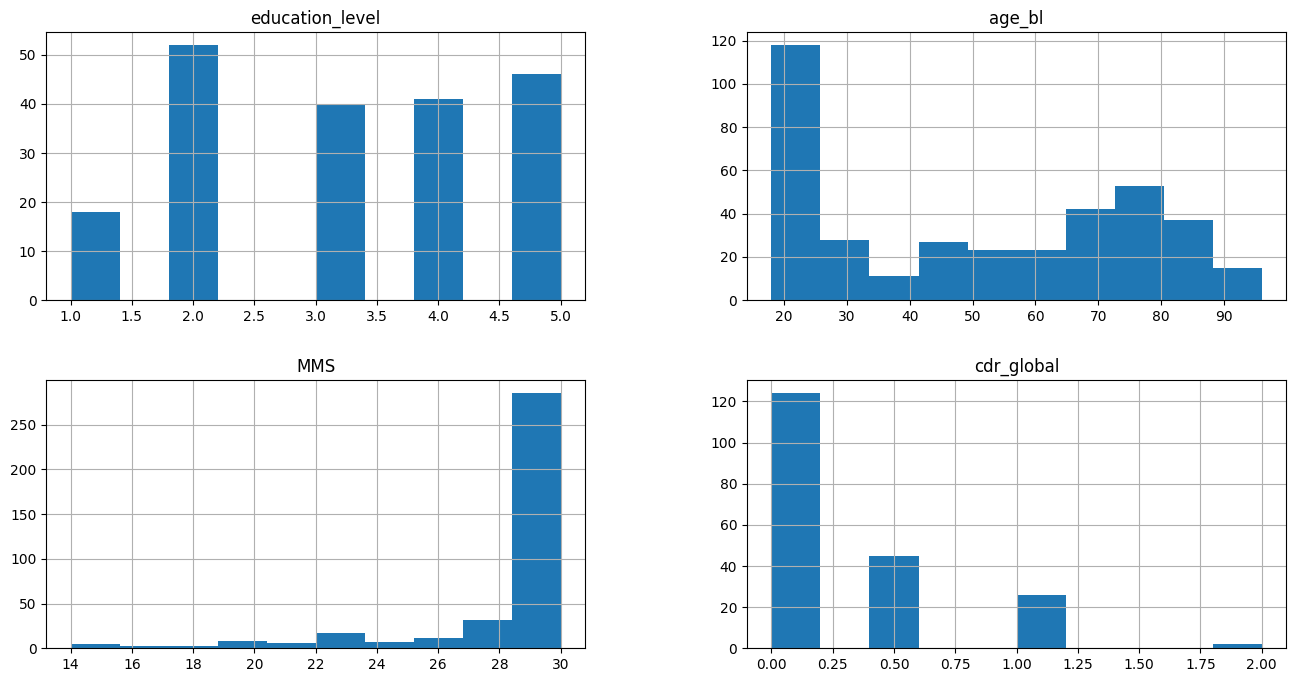

In [ ]:
# File path
file_path = 'OASIS-1_dataset/tsv_files/lab_1/OASIS_BIDS.tsv'

# Columns to load
columns_to_load = [
    'participant_id', 'session_id', 'alternative_id_1', 'sex',
    'education_level', 'age_bl', 'diagnosis_bl', 'laterality', 'MMS',
    'cdr_global', 'diagnosis']

# Read the CSV file using pandas of dataset
df_data = pd.read_csv(file_path, sep='\t', usecols=columns_to_load)
# Show first five items of the table
print(df_data.head())
# First visual inspection
_ = df_data.hist(figsize=(16, 8))

In [ ]:
class ds_MRI(Dataset):

    def __init__(self, image_directory, df_dataset, list_transforms=None):

        self.image_directory = image_directory
        self.list_transforms = list_transforms
        self.df_dataset = df_dataset
        self.diagnostic_code = {"AD": 1, "CN": 0}
        # Set the size attribute based on the shape of the first image in the dataset
        if len(self.df_dataset) > 0:
            self.size = self.__getitem__(0)['image'].shape
        else:
            raise ValueError("The dataset is empty, cannot determine image shape.")

    def __len__(self):
        return len(self.df_dataset)

    def __getitem__(self, idx):

        diag_stage = self.df_dataset.loc[idx, 'diagnosis']
        diagnosis_label = self.diagnostic_code[diag_stage]

        patient_id = self.df_dataset.loc[idx, 'participant_id']
        assignment_id = self.df_dataset.loc[idx, 'session_id']
        patient_file = (
            f'subjects/{patient_id}/{assignment_id}/'
            f'deeplearning_prepare_data/image_based/custom/'
            f'{patient_id}_{assignment_id}_T1w_segm-graymatter_space-Ixi549Space_modulated-off_probability.pt'
        )

        patient_image = torch.load(path.join(self.image_directory, patient_file))

        if self.list_transforms:
            patient_image = self.list_transforms(patient_image)

        sample = {'image': patient_image, 'label': diagnosis_label,
                  'participant_id': patient_id,
                  'session_id': assignment_id}
        return sample

    def train(self):
        self.list_transforms.train()

    def eval(self):
        self.list_transforms.eval()

In [ ]:
class CropRightHippoCampus(object):
    """Crops the right hippocampus of a MRI"""

    def __init__(self, rndm_move=0):
        self.rndm_move = rndm_move
        self.training_mode = True

    def __call__(self, img):
        if self.training_mode:
            x_dir = random.randint(-self.rndm_move, self.rndm_move)
            y_dir = random.randint(-self.rndm_move, self.rndm_move)
            z_dir = random.randint(-self.rndm_move, self.rndm_move)
        else:
            x_dir, y_dir, z_dir = 0, 0, 0

        # Calculate the indices for cropping
        x_start, x_end = 65 + x_dir, 95 + x_dir
        y_start, y_end = 50 + y_dir, 90 + y_dir
        z_start, z_end = 27 + z_dir, 57 + z_dir

        # Perform the crop and clone the resulting tensor
        return img[:, x_start:x_end, y_start:y_end, z_start:z_end].clone()

    def train(self):
        self.training_mode = True

    def eval(self):
        self.training_mode = False

In [ ]:
ds_train = pd.read_csv('OASIS-1_dataset/tsv_files/lab_1/train.tsv', sep='\t')
ds_test = pd.read_csv('OASIS-1_dataset/tsv_files/lab_1/validation.tsv', sep='\t')

class PadMaxPool3d(nn.Module):

    def __init__(self, kernel_size, stride, return_indices=False, return_pad=False):
            super().__init__()
            self.kernel_size = kernel_size
            self.stride = stride
            self.return_indices = return_indices
            self.return_pad = return_pad

            # Initialize the pooling and padding layers
            self.pool = nn.MaxPool3d(kernel_size=kernel_size, stride=stride, return_indices=return_indices)
            self.pad = nn.ConstantPad3d(padding=0, value=0)

    def forward(self, temp_map):
        coords = []
        for i in range(3):
            size = temp_map.size(i + 2)
            remainder = size % self.stride
            adjustment = self.stride - remainder
            coords.append(adjustment)

        coords = [0 if coord == self.stride else coord for coord in coords]

        self.pad.padding = (coords[2], 0, coords[1], 0, coords[0], 0)

        if self.return_indices:
            output, indices = self.pool(self.pad(temp_map))

            if self.return_pad:
                padding_info = (coords[2], 0, coords[1], 0, coords[0], 0)
                return output, indices, padding_info
            else:
                return output, indices

        else:
            output = self.pool(self.pad(temp_map))

            if self.return_pad:
                padding_info = (coords[2], 0, coords[1], 0, coords[0], 0)
                return output, padding_info
            else:
                return output

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock3D(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock3D, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv3d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.leaky_relu(out)
        return out

class CustomResNet3D(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2):
        super(CustomResNet3D, self).__init__()
        self.in_channels = 8

        self.conv1 = nn.Conv3d(1, 8, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(8)
        self.layer1 = self._make_layer(block, 8, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 16, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 32, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 64, num_blocks[3], stride=2)
        self.linear = nn.Linear(64 * block.expansion, num_classes)  # Adjusted output dimension

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.adaptive_avg_pool3d(x, (1, 1, 1))
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x


In [ ]:
import torch.nn as nn

def train(model, train_loader, val_loader, criterion, optimizer, n_epochs):

    best_model = deepcopy(model)
    train_best_loss = np.inf
    losses = {'train': [], 'val': []}

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        count = 0

        for data in train_loader:
            images, labels = data['image'].cuda(), data['label'].cuda()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            count += 1

        train_loss = total_loss / count
        losses['train'].append(train_loss)

        # Validation loss
        model.eval()
        total_val_loss = 0
        val_count = 0
        with torch.no_grad():
            for data in val_loader:
                images, labels = data['image'].cuda(), data['label'].cuda()
                outputs = model(images)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()
                val_count += 1

        val_loss = total_val_loss / val_count
        losses['val'].append(val_loss)

        print(f"Epoch {epoch}: Train loss = {train_loss:.4f}, Val loss = {val_loss:.4f}")

        if val_loss < train_best_loss:
            best_model = deepcopy(model)
            train_best_loss = val_loss

    return best_model, losses

def plot_losses_per_lr(losses_dict):
    """
    Plots training and validation losses for each learning rate in separate graphs.

    Args:
        losses_dict: Dictionary where key is the learning rate and value is another dict
                     containing 'train' and 'val' losses lists.
    """
    for lr, losses in losses_dict.items():
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(losses['train'], label='Training Loss', color='blue')
        plt.title(f'Training Loss (LR={lr})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(losses['val'], label='Validation Loss', color='red')
        plt.title(f'Validation Loss (LR={lr})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

def test(model, data_loader, criterion):

    model.eval()
    data_loader.dataset.eval()
    columns = ["participant_id", "proba0", "proba1", "true_label", "predicted_label"]
    final_df = pd.DataFrame(columns=columns)
    total_loss = 0

    # Disable gradient computation for validation/testing
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            # Move images and labels to GPU
            images = data['image'].cuda()
            labels = data['label'].cuda()
            # Forward pass: compute predicted outputs
            outputs = model(images)
            # Compute the loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            # Compute probabilities using Softmax
            probs = nn.Softmax(dim=1)(outputs)
            # Get the predicted class with the highest probability
            _, predicted = torch.max(outputs.data, 1)
            # Prepare data for the results DataFrame
            rows = [
                [
                    data['participant_id'][idx],
                    probs[idx, 0].item(),
                    probs[idx, 1].item(),
                    labels[idx].item(),
                    predicted[idx].item()
                ]
                for idx in range(len(data['participant_id']))
            ]

            # Create a DataFrame from the rows and concatenate to the results DataFrame
            batch_df = pd.DataFrame(rows, columns=columns)
            final_df = pd.concat([final_df, batch_df], ignore_index=True)

    # Convert the true_labels and predicted_labels to integers

    true_labels = final_df['true_label'].to_numpy(dtype=int)
    predicted_labels = final_df['predicted_label'].to_numpy(dtype=int)

    # Print unique values and types for debugging
    print("True labels unique values:", np.unique(true_labels), "Type:", true_labels.dtype)
    print("Predicted labels unique values:", np.unique(predicted_labels), "Type:", predicted_labels.dtype)

    # Compute metrics for true and predicted labels
    final_metrics = compute_metrics(true_labels, predicted_labels)

    # Reset the index of the results DataFrame
    final_df.reset_index(drop=True, inplace=True)

    # Calculate mean loss and add it to the results metrics
    mean_loss = total_loss / len(data_loader.dataset)
    final_metrics['mean_loss'] = mean_loss

    return final_df, final_metrics

def compute_metrics(ground_truth, prediction):
    """Computes the accuracy, sensitivity, specificity, balanced accuracy, and confusion matrix"""
    # Ensure that ground_truth and prediction are numpy arrays
    ground_truth = np.array(ground_truth)
    prediction = np.array(prediction)

    # Compute confusion matrix
    cm = confusion_matrix(ground_truth, prediction)

    true_positives = np.sum((prediction == 1) & (ground_truth == 1))
    true_negatives = np.sum((prediction == 0) & (ground_truth == 0))
    false_positives = np.sum((prediction == 1) & (ground_truth == 0))
    false_negatives = np.sum((prediction == 0) & (ground_truth == 1))

    metrics_dict = dict()
    metrics_dict['accuracy'] = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)

    # Sensitivity
    if true_positives + false_negatives != 0:
        metrics_dict['sensitivity'] = true_positives / (true_positives + false_negatives)
    else:
        metrics_dict['sensitivity'] = 0.0

    # Specificity
    if false_positives + true_negatives != 0:
        metrics_dict['specificity'] = true_negatives / (false_positives + true_negatives)
    else:
        metrics_dict['specificity'] = 0.0

    metrics_dict['balanced_accuracy'] = (metrics_dict['sensitivity'] + metrics_dict['specificity']) / 2
    metrics_dict['confusion_matrix'] = cm

    # Print the confusion matrix
    print("Confusion Matrix:\n", cm)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return metrics_dict

def plot_separate_losses(loss_history):
    """
    Function to plot training and validation losses on separate graphs for the best performing model.

    Args:
        loss_history: (dict) containing lists of training and validation losses
    """
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(loss_history['train'], label='Training Loss', color='blue')
    plt.title('Training Loss for Best Model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(loss_history['val'], label='Validation Loss', color='red')
    plt.title('Validation Loss for Best Model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def display_confusion_matrix(conf_matrix):
    """
    Displays the confusion matrix using seaborn heatmap.

    Args:
        conf_matrix: (numpy array) the confusion matrix
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for Best Model')
    plt.show()


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 1.2915, Val loss = 18.2773
Epoch 1: Train loss = 1.3440, Val loss = 9.6818
Epoch 2: Train loss = 1.0706, Val loss = 23.2934
Epoch 3: Train loss = 1.1800, Val loss = 10.3772
Epoch 4: Train loss = 1.3457, Val loss = 9.5292
Epoch 5: Train loss = 1.1433, Val loss = 7.8947
Epoch 6: Train loss = 1.1530, Val loss = 45.6461
Epoch 7: Train loss = 1.0574, Val loss = 16.5530
Epoch 8: Train loss = 1.0821, Val loss = 10.1129
Epoch 9: Train loss = 1.0412, Val loss = 25.3444
Epoch 10: Train loss = 1.0739, Val loss = 7.0649
Epoch 11: Train loss = 1.0750, Val loss = 7.0841
Epoch 12: Train loss = 1.0318, Val loss = 85.0089
Epoch 13: Train loss = 0.9960, Val loss = 35.2022
Epoch 14: Train loss = 1.0256, Val loss = 20.3233
Epoch 15: Train loss = 1.0262, Val loss = 25.4276
Epoch 16: Train loss = 0.9678, Val loss = 8.7581
Epoch 17: Train loss = 0.9077, Val loss = 14.7208
Epoch 18: Train loss = 0.8731, Val loss = 10.1376
Epoch 19: Train loss = 0.9023, Val loss = 7.8880
Epoch 20: Train l

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[56  6]
 [ 4 11]]


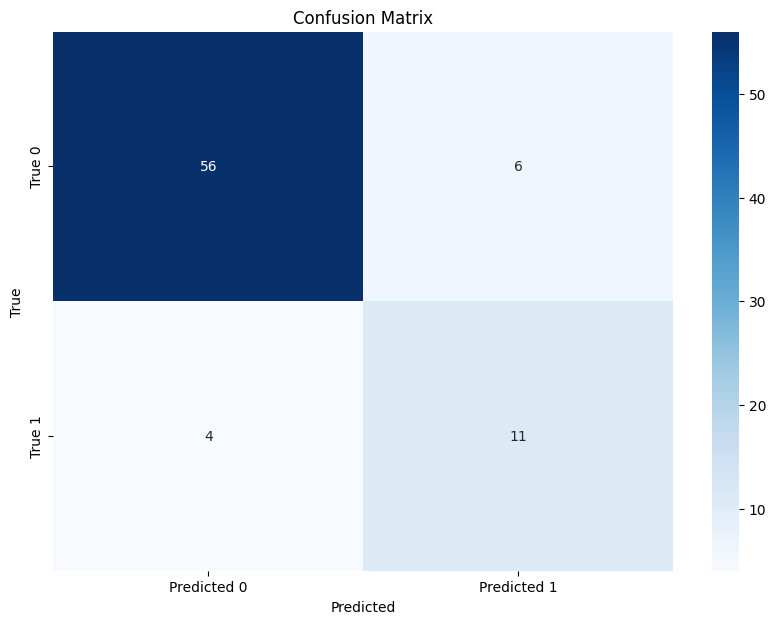

Learning Rate: 0.001 - Validation Accuracy: 0.8701298701298701


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 1.3941, Val loss = 8.2249
Epoch 1: Train loss = 1.1901, Val loss = 390.7694
Epoch 2: Train loss = 1.1265, Val loss = 7.9672
Epoch 3: Train loss = 1.2483, Val loss = 24.1729
Epoch 4: Train loss = 1.2142, Val loss = 35.9996
Epoch 5: Train loss = 1.0574, Val loss = 82.9311
Epoch 6: Train loss = 1.3321, Val loss = 9.9101
Epoch 7: Train loss = 0.9730, Val loss = 7.6491
Epoch 8: Train loss = 1.0747, Val loss = 7.4575
Epoch 9: Train loss = 1.0926, Val loss = 7.8983
Epoch 10: Train loss = 1.0283, Val loss = 8.7041
Epoch 11: Train loss = 0.8740, Val loss = 13.6912
Epoch 12: Train loss = 0.9103, Val loss = 49.7174
Epoch 13: Train loss = 1.2141, Val loss = 12.1769
Epoch 14: Train loss = 1.1387, Val loss = 8.5620
Epoch 15: Train loss = 1.1018, Val loss = 8.3503
Epoch 16: Train loss = 0.8769, Val loss = 7.3675
Epoch 17: Train loss = 1.1021, Val loss = 8.0051
Epoch 18: Train loss = 1.2517, Val loss = 7.9828
Epoch 19: Train loss = 0.8566, Val loss = 8.9487
Epoch 20: Train loss =

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[53  9]
 [ 3 12]]


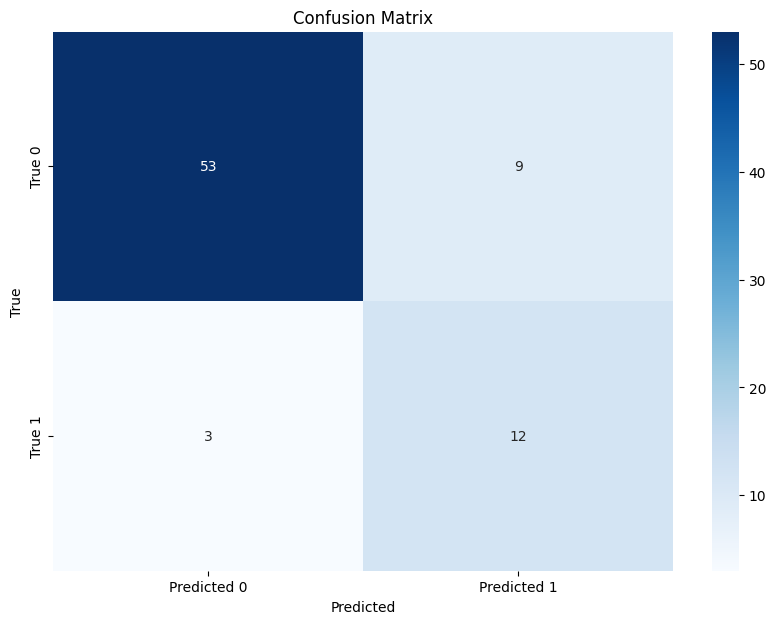

Learning Rate: 0.0005 - Validation Accuracy: 0.8441558441558441


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 1.6453, Val loss = 10.5048
Epoch 1: Train loss = 0.9696, Val loss = 19.9070
Epoch 2: Train loss = 0.8098, Val loss = 25.4076
Epoch 3: Train loss = 0.3805, Val loss = 8.3257
Epoch 4: Train loss = 0.3065, Val loss = 20.1838
Epoch 5: Train loss = 0.4765, Val loss = 12.6987
Epoch 6: Train loss = 0.1849, Val loss = 8.4524
Epoch 7: Train loss = 0.3406, Val loss = 5.6621
Epoch 8: Train loss = 0.1134, Val loss = 6.6981
Epoch 9: Train loss = 0.1827, Val loss = 11.0206
Epoch 10: Train loss = 0.1307, Val loss = 7.3305
Epoch 11: Train loss = 0.0876, Val loss = 6.1030
Epoch 12: Train loss = 0.0346, Val loss = 10.1239
Epoch 13: Train loss = 0.0286, Val loss = 10.1678
Epoch 14: Train loss = 0.2637, Val loss = 23.2926
Epoch 15: Train loss = 0.0874, Val loss = 8.2471
Epoch 16: Train loss = 0.2835, Val loss = 13.4232
Epoch 17: Train loss = 0.2095, Val loss = 10.9073
Epoch 18: Train loss = 0.0479, Val loss = 8.8695
Epoch 19: Train loss = 0.0871, Val loss = 7.1544
Epoch 20: Train los

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[59  3]
 [ 5 10]]


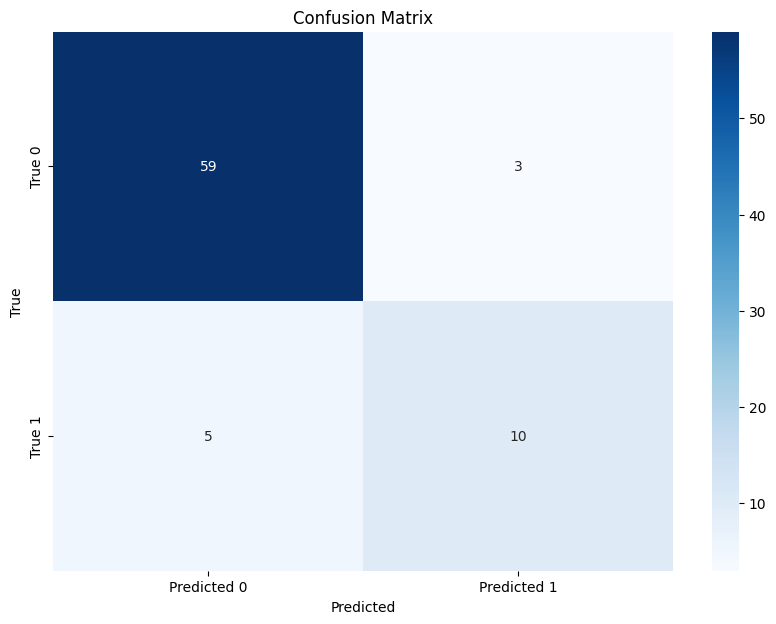

Learning Rate: 0.0001 - Validation Accuracy: 0.8961038961038961


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 2.1753, Val loss = 8.4530
Epoch 1: Train loss = 1.1297, Val loss = 8.3879
Epoch 2: Train loss = 0.6605, Val loss = 9.8994
Epoch 3: Train loss = 0.3733, Val loss = 10.8661
Epoch 4: Train loss = 0.2864, Val loss = 11.8954
Epoch 5: Train loss = 0.3376, Val loss = 13.3428
Epoch 6: Train loss = 0.4687, Val loss = 17.3577
Epoch 7: Train loss = 0.2619, Val loss = 12.2594
Epoch 8: Train loss = 0.1817, Val loss = 10.0007
Epoch 9: Train loss = 0.1649, Val loss = 9.6775
Epoch 10: Train loss = 0.1349, Val loss = 11.5157
Epoch 11: Train loss = 0.1017, Val loss = 10.6319
Epoch 12: Train loss = 0.0691, Val loss = 13.3585
Epoch 13: Train loss = 0.0799, Val loss = 14.9554
Epoch 14: Train loss = 0.3372, Val loss = 10.7406
Epoch 15: Train loss = 0.2171, Val loss = 21.3506
Epoch 16: Train loss = 0.1437, Val loss = 10.3392
Epoch 17: Train loss = 0.0594, Val loss = 9.6599
Epoch 18: Train loss = 0.0499, Val loss = 11.2831
Epoch 19: Train loss = 0.0322, Val loss = 12.1728
Epoch 20: Train

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[59  3]
 [10  5]]


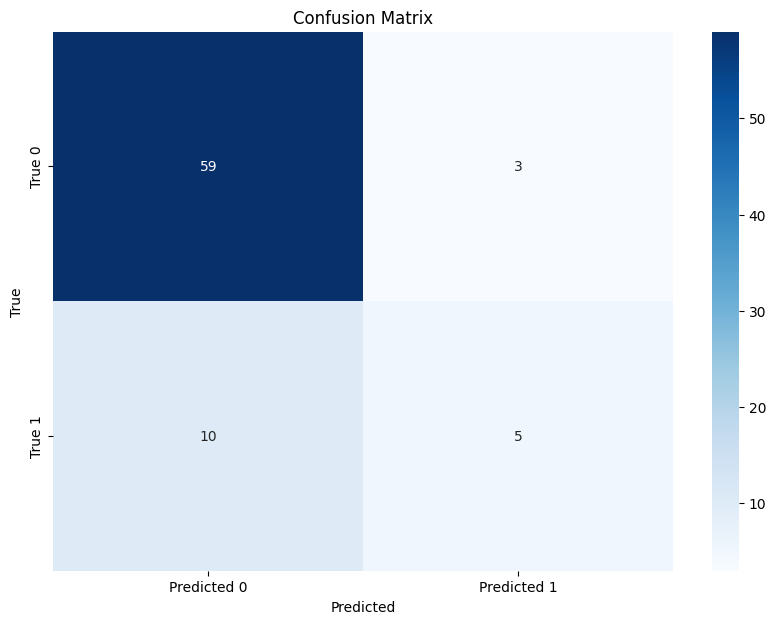

Learning Rate: 5e-05 - Validation Accuracy: 0.8311688311688312


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 2.0508, Val loss = 12.3749
Epoch 1: Train loss = 1.7849, Val loss = 10.6801
Epoch 2: Train loss = 1.3021, Val loss = 8.2321
Epoch 3: Train loss = 0.9516, Val loss = 10.2602
Epoch 4: Train loss = 0.7028, Val loss = 9.1867
Epoch 5: Train loss = 0.6634, Val loss = 8.5475
Epoch 6: Train loss = 0.4286, Val loss = 8.4064
Epoch 7: Train loss = 0.4161, Val loss = 11.6969
Epoch 8: Train loss = 0.3347, Val loss = 10.3015
Epoch 9: Train loss = 0.3748, Val loss = 9.5054
Epoch 10: Train loss = 0.3360, Val loss = 11.0801
Epoch 11: Train loss = 0.3126, Val loss = 10.7529
Epoch 12: Train loss = 0.4008, Val loss = 9.9580
Epoch 13: Train loss = 0.2845, Val loss = 8.6490
Epoch 14: Train loss = 0.2322, Val loss = 14.5884
Epoch 15: Train loss = 0.2038, Val loss = 9.3137
Epoch 16: Train loss = 0.2091, Val loss = 11.2509
Epoch 17: Train loss = 0.2322, Val loss = 12.4777
Epoch 18: Train loss = 0.1674, Val loss = 10.3461
Epoch 19: Train loss = 0.1733, Val loss = 9.2716
Epoch 20: Train los

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[61  1]
 [ 8  7]]


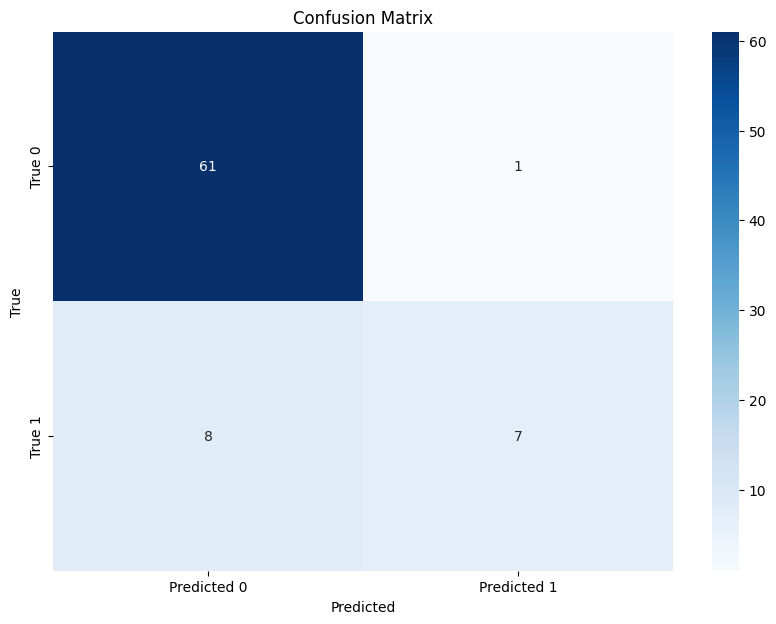

Learning Rate: 1e-05 - Validation Accuracy: 0.8831168831168831


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 2.9329, Val loss = 18.6857
Epoch 1: Train loss = 2.8487, Val loss = 18.3189
Epoch 2: Train loss = 2.7710, Val loss = 17.8785
Epoch 3: Train loss = 2.6950, Val loss = 17.4521
Epoch 4: Train loss = 2.6178, Val loss = 16.9696
Epoch 5: Train loss = 2.5439, Val loss = 16.5442
Epoch 6: Train loss = 2.4682, Val loss = 16.1507
Epoch 7: Train loss = 2.4063, Val loss = 15.8258
Epoch 8: Train loss = 2.3370, Val loss = 15.4960
Epoch 9: Train loss = 2.2681, Val loss = 15.1523
Epoch 10: Train loss = 2.2151, Val loss = 14.7216
Epoch 11: Train loss = 2.1552, Val loss = 14.5157
Epoch 12: Train loss = 2.0932, Val loss = 14.0127
Epoch 13: Train loss = 2.0241, Val loss = 13.7718
Epoch 14: Train loss = 1.9997, Val loss = 13.6663
Epoch 15: Train loss = 1.9106, Val loss = 13.4535
Epoch 16: Train loss = 1.8808, Val loss = 12.7040
Epoch 17: Train loss = 1.8009, Val loss = 12.8151
Epoch 18: Train loss = 1.7421, Val loss = 12.7795
Epoch 19: Train loss = 1.6491, Val loss = 12.5369
Epoch 20: 

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[55  7]
 [ 7  8]]


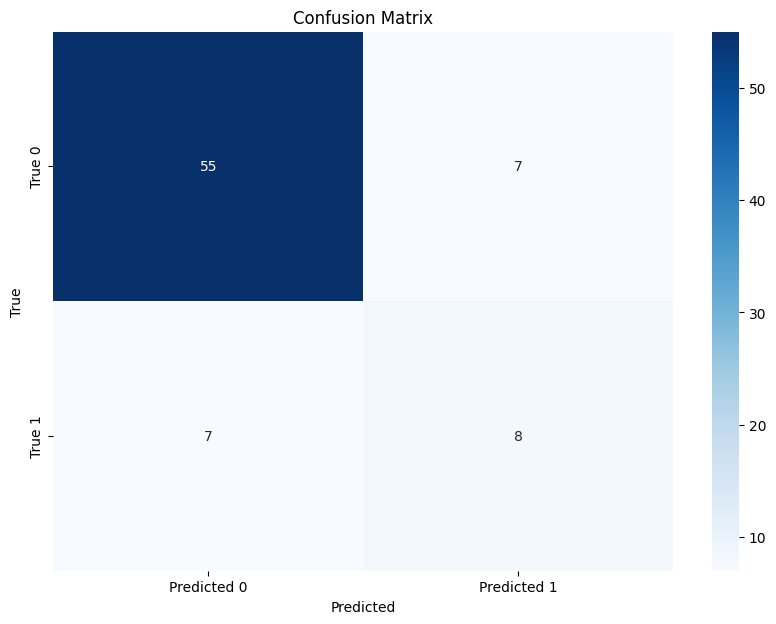

Learning Rate: 1e-06 - Validation Accuracy: 0.8181818181818182


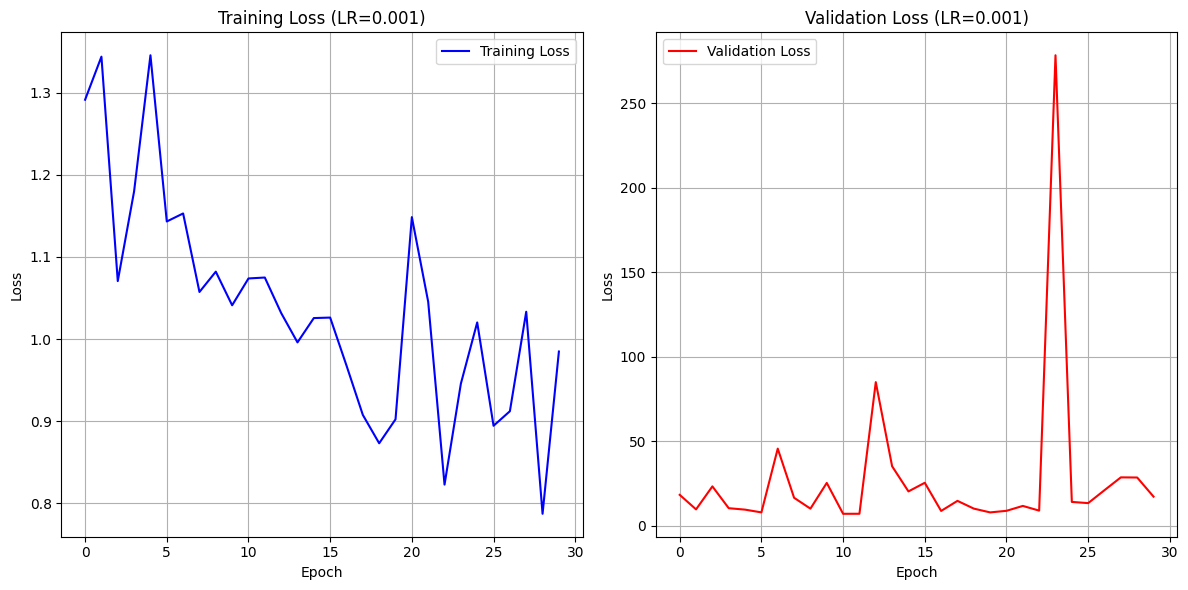

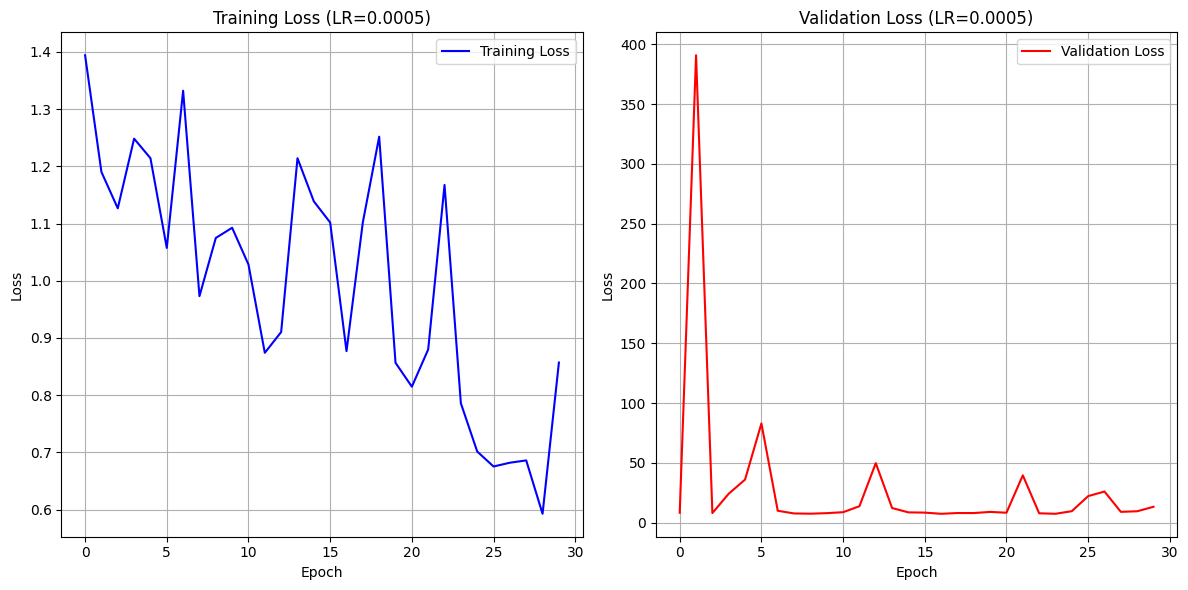

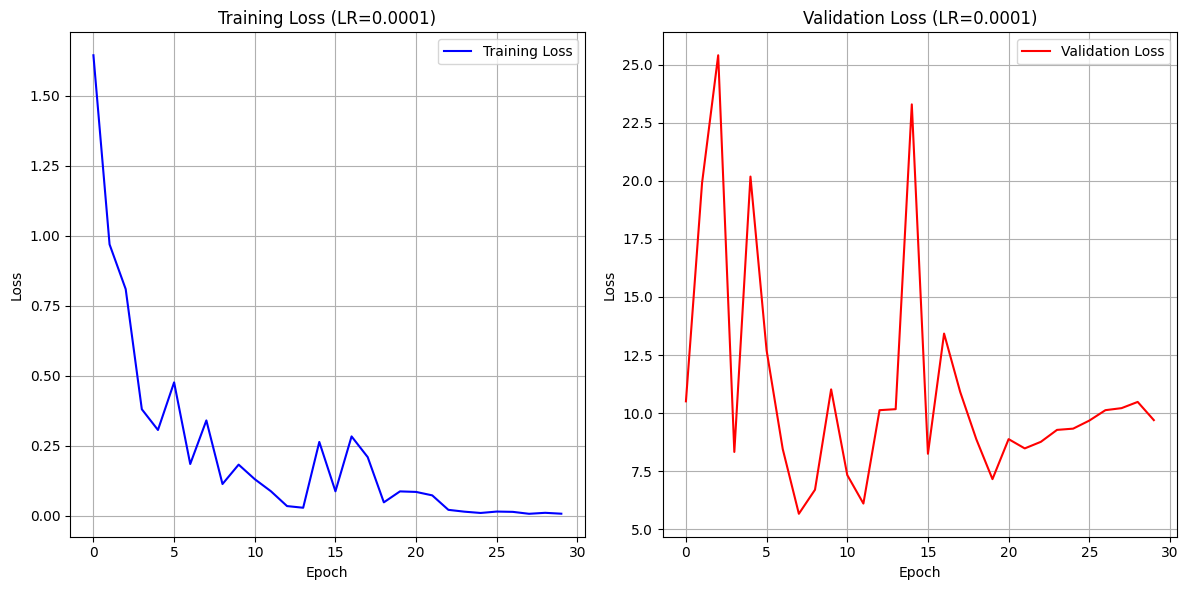

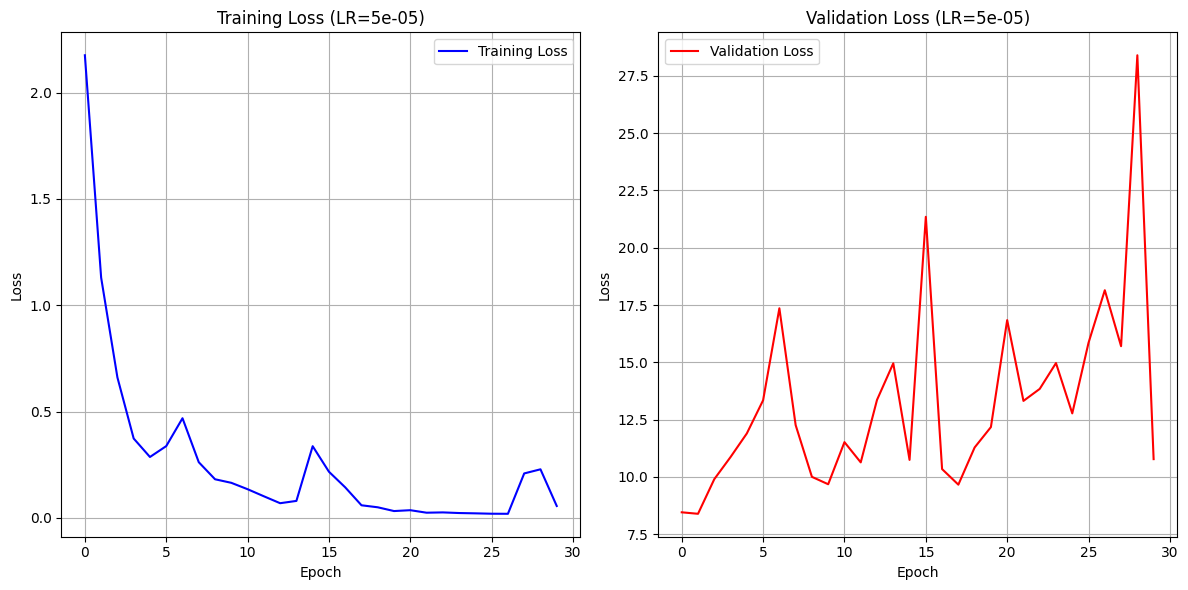

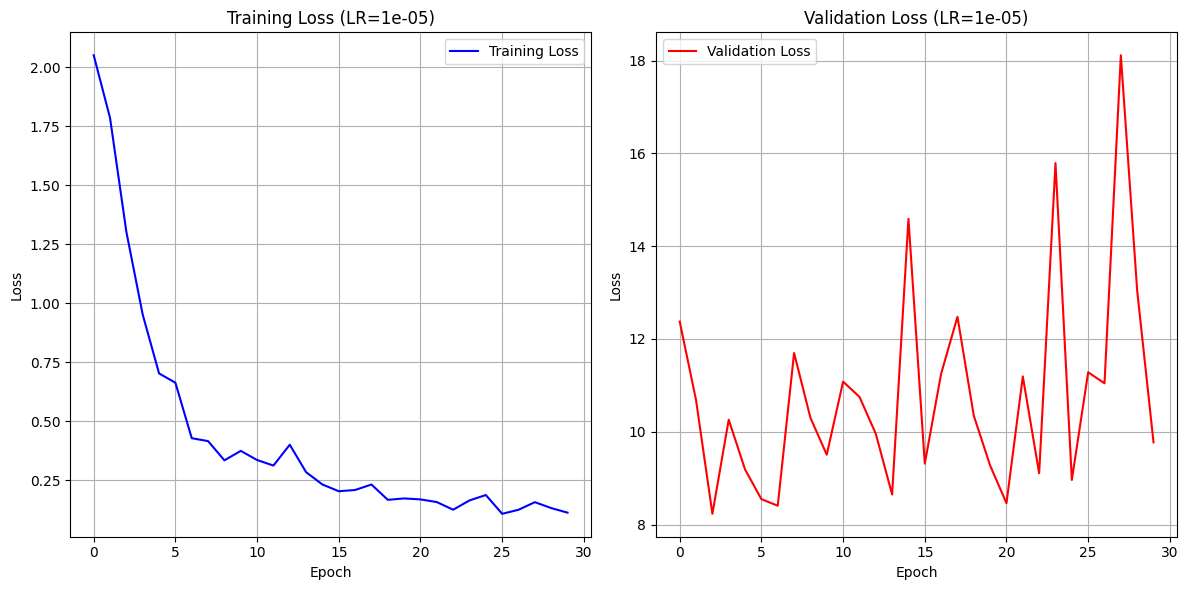

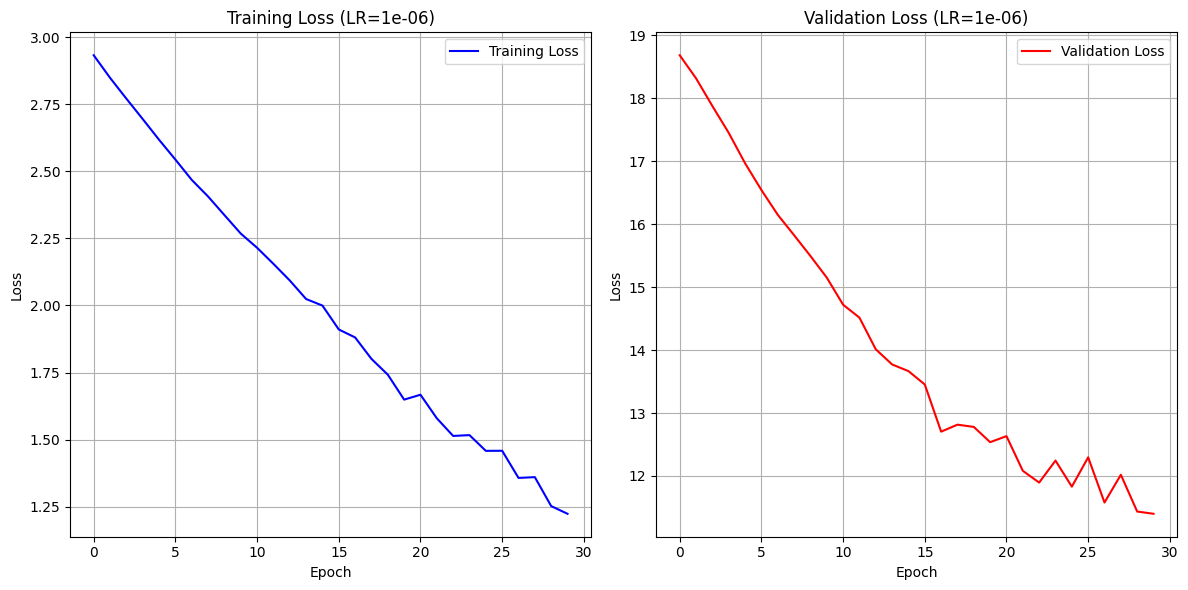

In [ ]:
import itertools
# Path setup, dataset, and transforms

image_directory = path.join('OASIS-1_dataset', 'CAPS')
list_transforms = CropRightHippoCampus(2)

train_RightHippoCampus = ds_MRI(image_directory, ds_train, list_transforms=list_transforms)
test_RightHippoCampus = ds_MRI(image_directory, ds_test, list_transforms=list_transforms)

# Hyperparameter setup
learning_rates = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 1e-6]
n_epochs = 30
batch_size = 4
loss_histories = {}

# Training and validation setup
for lr in learning_rates:
    model_RightHippoCampus = CustomResNet3D(BasicBlock3D, [3, 4, 6, 3], num_classes=2).cuda()
    optimizer = torch.optim.Adam(model_RightHippoCampus.parameters(), lr=lr)
    trainloader_RightHC = DataLoader(train_RightHippoCampus, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
    testloader_RightHC = DataLoader(test_RightHippoCampus, batch_size=32, shuffle=False, num_workers=8, pin_memory=True)

    # Train and evaluate the model
    best_model, losses = train(model_RightHippoCampus, trainloader_RightHC, testloader_RightHC, nn.CrossEntropyLoss(reduction='sum').cuda(), optimizer, n_epochs)
    loss_histories[lr] = losses

    # Evaluate the model
    valid_resultsLeftHC_df, valid_metricsLeftHC  = test(best_model, testloader_RightHC, nn.CrossEntropyLoss(reduction='sum').cuda())
    print(f"Learning Rate: {lr} - Validation Accuracy: {valid_metricsLeftHC['accuracy']}")

# Plot losses for each learning rate
plot_losses_per_lr(loss_histories)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 3.7975, Val loss = 20.9292
Epoch 1: Train loss = 3.0971, Val loss = 14.4377
Epoch 2: Train loss = 2.4855, Val loss = 10.1521
Epoch 3: Train loss = 2.0554, Val loss = 9.6576
Epoch 4: Train loss = 1.7520, Val loss = 10.3647
Epoch 5: Train loss = 1.7182, Val loss = 9.6894
Epoch 6: Train loss = 1.5295, Val loss = 10.0393
Epoch 7: Train loss = 1.4782, Val loss = 8.5204
Epoch 8: Train loss = 1.4257, Val loss = 7.9410
Epoch 9: Train loss = 1.3578, Val loss = 8.5598
Epoch 10: Train loss = 1.3559, Val loss = 8.3324
Epoch 11: Train loss = 1.3000, Val loss = 8.1253
Epoch 12: Train loss = 1.2130, Val loss = 8.1546
Epoch 13: Train loss = 1.2049, Val loss = 7.4303
Epoch 14: Train loss = 1.1671, Val loss = 7.9700
Epoch 15: Train loss = 1.1934, Val loss = 7.5968
Epoch 16: Train loss = 1.1230, Val loss = 7.6036
Epoch 17: Train loss = 1.1749, Val loss = 7.1702
Epoch 18: Train loss = 1.1635, Val loss = 7.6877
Epoch 19: Train loss = 1.1270, Val loss = 7.4808
Epoch 20: Train loss = 1.

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[55  7]
 [ 4 11]]


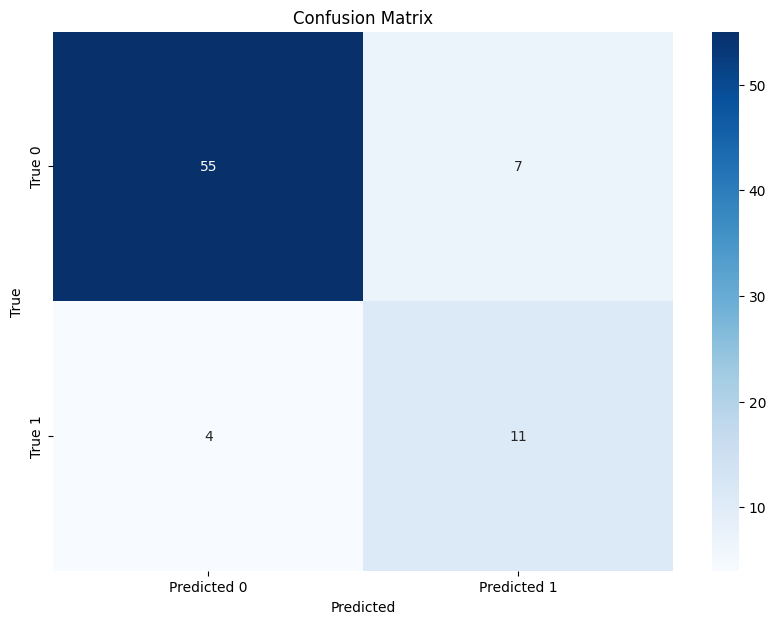

Learning Rate: 5e-06 - Validation Accuracy: 0.8571428571428571


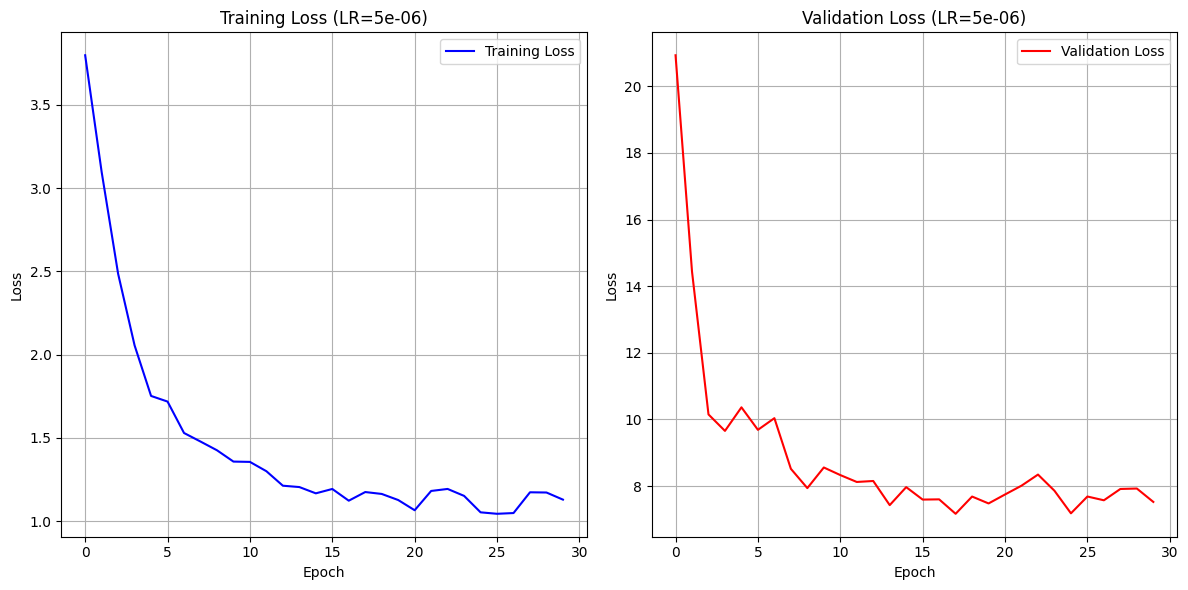

In [ ]:
import itertools
# Path setup, dataset, and transforms

image_directory = path.join('OASIS-1_dataset', 'CAPS')
list_transforms = CropRightHippoCampus(2)

train_RightHippoCampus = ds_MRI(image_directory, ds_train, list_transforms=list_transforms)
test_RightHippoCampus = ds_MRI(image_directory, ds_test, list_transforms=list_transforms)

# Hyperparameter setup
learning_rates = [5e-6]
n_epochs = 30
batch_size = 4
loss_histories = {}

# Training and validation setup
for lr in learning_rates:
    model_RightHippoCampus = CustomResNet3D(BasicBlock3D, [3, 4, 6, 3], num_classes=2).cuda()
    optimizer = torch.optim.Adam(model_RightHippoCampus.parameters(), lr=lr)
    trainloader_RightHC = DataLoader(train_RightHippoCampus, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
    testloader_RightHC = DataLoader(test_RightHippoCampus, batch_size=32, shuffle=False, num_workers=8, pin_memory=True)

    # Train and evaluate the model
    best_model, losses = train(model_RightHippoCampus, trainloader_RightHC, testloader_RightHC, nn.CrossEntropyLoss(reduction='sum').cuda(), optimizer, n_epochs)
    loss_histories[lr] = losses

    # Evaluate the model
    valid_resultsLeftHC_df, valid_metricsLeftHC  = test(best_model, testloader_RightHC, nn.CrossEntropyLoss(reduction='sum').cuda())
    print(f"Learning Rate: {lr} - Validation Accuracy: {valid_metricsLeftHC['accuracy']}")

# Plot losses for each learning rate
plot_losses_per_lr(loss_histories)